In [1]:
!pip install transformers

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

Importing Google Colab stuff to mount drive where yelp data is saved

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_data_path = '/content/drive/MyDrive/ML/Final_project/yelp_review_train-2.csv'
test_data_path = '/content/drive/MyDrive/ML/Final_project/yelp_review_test-2.csv'

In [5]:
df = pd.read_csv(train_data_path)

In [6]:
test_df = pd.read_csv(test_data_path)

In [7]:
df.head()

,text,stars
0,Went for lunch and found that my burger was me...,2.0
1,I needed a new tires for my wife's car. They h...,5.0
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0
3,Been here a few times to get some shrimp. The...,4.0
4,This is one fantastic place to eat whether you...,5.0


In [8]:
test_df.head()

,text,stars
0,"Hidden treasure! Awesome service, delicious fo...",5.0
1,My family and I have been patients since I wa...,5.0
2,"I rarely get pedicures, but Blue Nail's practi...",5.0
3,"We came with a large group, may of the items w...",2.0
4,The view is great from Morgan's Pier. The bart...,2.0


In [9]:
# Download NLTK stopwords (if not already downloaded)
nltk.download('stopwords')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation using regular expressions
    text = re.sub(r'[^\w\s]', '', text)

    return text

# Apply text preprocessing to the 'review text' column
df['text'] = df['text'].apply(preprocess_text)

# Remove stopwords using NLTK
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Convert stars into three levels: Positive > 3, negative <= 2, and neutral = 3
df['sentiment'] = pd.cut(df['stars'], bins=[-float('inf'), 2, 3, float('inf')], labels=['negative', 'neutral', 'positive'])

# Display the preprocessed data
print(df[['text', 'sentiment']])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                                     text sentiment
0       went lunch found burger meh obvious focus burg...  negative
1       needed new tires wifes car special order next ...  positive
2       jim woltman works goleta honda 5 stars knowled...  positive
3       times get shrimp theyve got nice selection dif...  positive
4       one fantastic place eat whether hungry need go...  positive
...                                                   ...       ...
174752  oy great partially fault holy smokes daughter ...  negative
174753  im huge fan chocolate maya high quality ingred...  positive
174754  hosted wedding ceremony could happier everythi...  positive
174755  love place fantastic lunch specials get 3 roll...  positive
174756  happy service food one best tasting turkey bur...  positive

[174757 rows x 2 columns]


Performed Preprocessing of data
download the NLTK stopwords and
then define a text preprocessing function under which it applies the preprocessing to a ’text’ column in a DataFrame, removing stopwords and converting text to lowercase and then it categorizes sentiment based on star ratings into negative,
neutral, and positive based on following conditions, Positive > 3, negative <= 2,
and neutral = 3 levels.


Similar procedure for test data

In [10]:
# Apply text preprocessing to the 'review text' column
test_df['text'] = test_df['text'].apply(preprocess_text)

# Remove stopwords using NLTK
stop_words = set(stopwords.words('english'))
test_df['text'] = test_df['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Convert stars into three levels: Positive > 3, negative <= 2, and neutral = 3
test_df['sentiment'] = pd.cut(test_df['stars'], bins=[-float('inf'), 2, 3, float('inf')], labels=['negative', 'neutral', 'positive'])

# Display the preprocessed data
print(test_df[['text', 'sentiment']])


                                                    text sentiment
0      hidden treasure awesome service delicious food...  positive
1      family patients since 5 years old 34 trust qua...  positive
2      rarely get pedicures blue nails practice combi...  positive
3      came large group may items missing menu lobste...  negative
4      view great morgans pier bartenders even good s...  negative
...                                                  ...       ...
13975  amazing food opened new place princeton lamb s...  positive
13976  thanks great planning store wonderful black fr...  positive
13977  classic nola white tablecloth dining experienc...  positive
13978  waiting 15 minutes without much someone taking...  negative
13979  guys come clean gutters 2 story house way wind...  positive

[13980 rows x 2 columns]


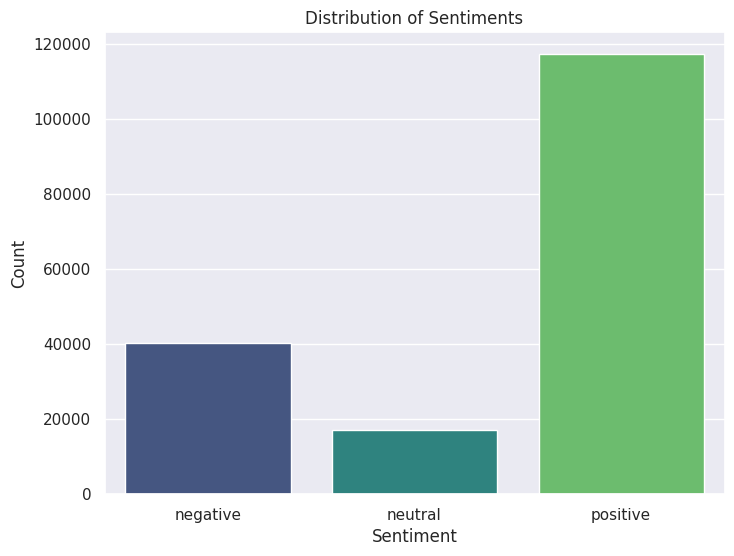

In [12]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette="viridis")

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Display the plot
plt.show()

In [13]:
print(df[df["sentiment"] == "positive"].count())
print(df[df["sentiment"] == "negative"].count())
print(df[df["sentiment"] == "neutral"].count())

text         117177
stars        117177
sentiment    117177
dtype: int64
text         40345
stars        40345
sentiment    40345
dtype: int64
text         17235
stars        17235
sentiment    17235
dtype: int64


The count shows that there is no imbalance in the data and if there was any imbalance in the data then we would have applied stratisfied sampling but still to ensure that there is no imbalance we will apply stratisfied sampling.

In [14]:
df.head()

,text,stars,sentiment
0,went lunch found burger meh obvious focus burg...,2.0,negative
1,needed new tires wifes car special order next ...,5.0,positive
2,jim woltman works goleta honda 5 stars knowled...,5.0,positive
3,times get shrimp theyve got nice selection dif...,4.0,positive
4,one fantastic place eat whether hungry need go...,5.0,positive


In [15]:
test_df.head()

,text,stars,sentiment
0,hidden treasure awesome service delicious food...,5.0,positive
1,family patients since 5 years old 34 trust qua...,5.0,positive
2,rarely get pedicures blue nails practice combi...,5.0,positive
3,came large group may items missing menu lobste...,2.0,negative
4,view great morgans pier bartenders even good s...,2.0,negative


Applied Stratified sampling

In [16]:
# Stratified sampling to ensure class distribution is maintained
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

# Check the class distribution in the training set
print("Training Set Class Distribution:")
print(train_df['sentiment'].value_counts(normalize=True))

# Check the class distribution in the validation set
print("\nValidation Set Class Distribution:")
print(val_df['sentiment'].value_counts(normalize=True))

Training Set Class Distribution:
positive    0.670512
negative    0.230864
neutral     0.098623
Name: sentiment, dtype: float64

Validation Set Class Distribution:
positive    0.670520
negative    0.230859
neutral     0.098621
Name: sentiment, dtype: float64


text         93741
stars        93741
sentiment    93741
dtype: int64
text         32276
stars        32276
sentiment    32276
dtype: int64
text         13788
stars        13788
sentiment    13788
dtype: int64


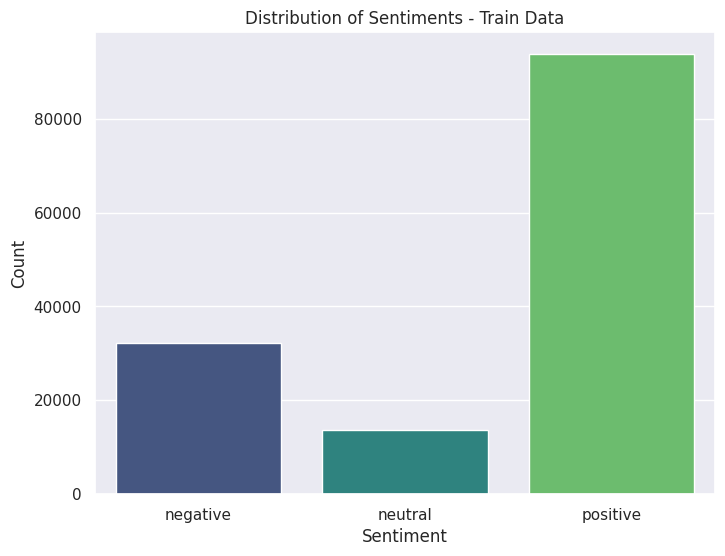

In [17]:
print(train_df[train_df["sentiment"] == "positive"].count())
print(train_df[train_df["sentiment"] == "negative"].count())
print(train_df[train_df["sentiment"] == "neutral"].count())

sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=train_df, palette="viridis")

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments - Train Data')

# Display the plot
plt.show()

text         23436
stars        23436
sentiment    23436
dtype: int64
text         8069
stars        8069
sentiment    8069
dtype: int64
text         3447
stars        3447
sentiment    3447
dtype: int64


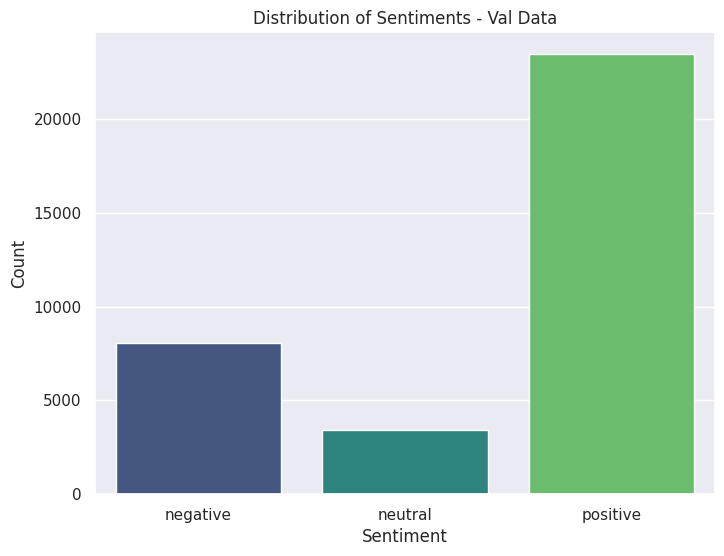

In [18]:
print(val_df[val_df["sentiment"] == "positive"].count())
print(val_df[val_df["sentiment"] == "negative"].count())
print(val_df[val_df["sentiment"] == "neutral"].count())

sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=val_df, palette="viridis")

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments - Val Data')

# Display the plot
plt.show()

Validation and Training data also has the same target distribution

In [19]:
train_df['split'] = 'train'
val_df['split'] = 'val'

# Merge the training and validation DataFrames into a single DataFrame
df = pd.concat([train_df, val_df], ignore_index=True)

In [20]:
df

,text,stars,sentiment,split
0,speak experience take side walked everyone wor...,1.0,negative,train
1,stopped late lunch nice quiet dining room serv...,4.0,positive,train
2,frustrating customer service experience tree z...,1.0,negative,train
3,wish nashville spot like trendy little breakfa...,5.0,positive,train
4,dream sharp italian always say going try somet...,5.0,positive,train
...,...,...,...,...
174752,stopped lunch today wonderful meal couple doze...,4.0,positive,val
174753,hands best service weve restaurant quite altho...,5.0,positive,val
174754,dont skip joint tour cool divey places great b...,5.0,positive,val
174755,awesome spicy tuna rolls fantastic service fav...,4.0,positive,val


In [21]:
df.sentiment = df.sentiment.apply({'negative':0,'positive':1, 'neutral': 2}.get)

In [22]:
test_df.sentiment = test_df.sentiment.apply({'negative':0,'positive':1, 'neutral': 2}.get)

In [23]:
df.head()

,text,stars,sentiment,split
0,speak experience take side walked everyone wor...,1.0,0,train
1,stopped late lunch nice quiet dining room serv...,4.0,1,train
2,frustrating customer service experience tree z...,1.0,0,train
3,wish nashville spot like trendy little breakfa...,5.0,1,train
4,dream sharp italian always say going try somet...,5.0,1,train


In [24]:
test_df.head()

,text,stars,sentiment
0,hidden treasure awesome service delicious food...,5.0,1
1,family patients since 5 years old 34 trust qua...,5.0,1
2,rarely get pedicures blue nails practice combi...,5.0,1
3,came large group may items missing menu lobste...,2.0,0
4,view great morgans pier bartenders even good s...,2.0,0


In [25]:
class_name = ['negative','positive','neutral']

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Setting device as per the availability

In [27]:
device

device(type='cuda', index=0)

In [28]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [29]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loading pre-trained bert tokenizer

100%|██████████| 174757/174757 [04:00<00:00, 725.22it/s]


<Axes: ylabel='Density'>

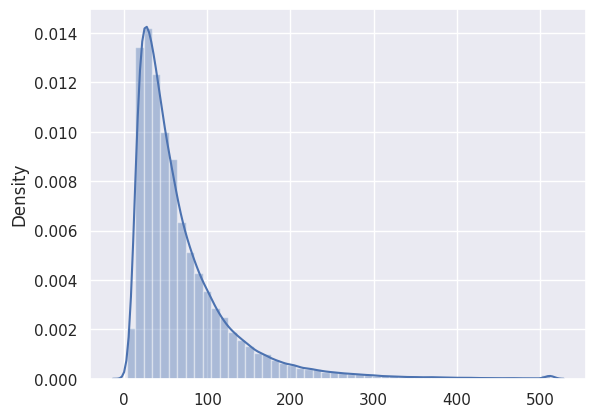

In [30]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(df.text):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)


the max-len of the sentence. The max length of the sentence is 520 but the system was getting crashed so to make it work, we experimented with different lenghts in decreasing order and 512 length worked well

100%|██████████| 13980/13980 [00:18<00:00, 755.93it/s]


<Axes: ylabel='Density'>

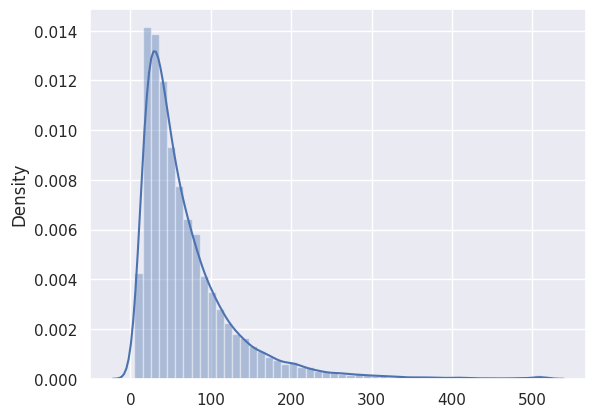

In [31]:
from tqdm import tqdm
test_token_lens = []
for txt in tqdm(test_df.text):
  tokens = tokenizer.encode(txt, max_length=512)
  test_token_lens.append(len(tokens))

sns.distplot(test_token_lens)


In [32]:
MAX_LEN = 120

In [33]:
from torch.utils.data import Dataset, DataLoader
class ReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

Creating Pytorch dataset by converting the text into numerical vectors using the tokenizer


In [34]:
df_train = df[df['split']=='train']
df_val = df[df['split']=='val']
# df_test = df[df['split']=='test']

In [35]:
df_train.shape, df_val.shape, test_df.shape

((139805, 4), (34952, 4), (13980, 3))

In [36]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(df_train.sentiment.values),
                                                 y=df_train.sentiment.values)

In [37]:
class_weights

array([1.44384889, 0.49713217, 3.37987139])

In [38]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = ReviewDataset(
        reviews = df.text.to_numpy(),
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=4)

Creating Pytorch dataset loader

We will define a custom PyTorch
dataset (‘ReviewDataset‘) for text reviews and corresponding sentiment targets.
The dataset utilizes a tokenizer to encode the text, ensuring a specified maximum
length. It will return a dictionary containing the original review text, input IDs,
attention mask, and the sentiment target, suitable for training a neural network.
Batch size is a crucial aspect of training machine learning models, including those
used in sentiment analysis. The batch size determines the number of samples
that will be processed in each iteration during training.
So, Experimented with the batch - size of the data. First took 64 as size
but it didn’t work as it was taking alot of memory and then tried with the half
of the number that previously took which is 32 and it worked very well.

In [39]:
BATCH_SIZE = 32
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [40]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [41]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

Creating a fine-tuned bert model

We will create a BERT model and train it with
hyperparameter as number of epochs and is equal to 10 and then train and
evaluate the model on each epochs but later when we evaluate the model it
results into overusage of RAM. So slowly decreased the number of epochs and it
reaches to 2 when it started working again and give the result in terms of loss
and accuracy of training and validation set respectively.

In [42]:
model = SentimentClassifier(len(class_name))
model = model.to(device)

In [43]:
import math
import os

In [44]:
EPOCHS = 2
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = math.ceil(len(train_data_loader)/BATCH_SIZE) * EPOCHS
# total_steps = math.ceil(len(train_data_loader)/BATCH_SIZE)
# total_steps = 1000 * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
#class_weights = torch.FloatTensor(class_weights).to(device)
#weight=class_weights
loss_fn = nn.CrossEntropyLoss().to(device)

initializing optimizer and loss function for our model

In [45]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


function to train our model on each epoch

In [46]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

function to evaluate the model

In [47]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

In [48]:
saved_model_path = './best_model_state.bin'
if os.path.exists(saved_model_path):
    # Load the saved model, optimizer, and scheduler states
    checkpoint = torch.load(saved_model_path)
    # model.load_state_dict(checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_accuracy = checkpoint['best_accuracy']
    start_epoch = checkpoint['epoch'] + 1  # Start the next epoch
    history = checkpoint['history']
    start_epoch = 4
    print("Loaded model, optimizer, and scheduler states from:", saved_model_path)
else:
    start_epoch = 0

In [49]:
for epoch in range(start_epoch,EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'history': history,
            'best_accuracy': best_accuracy,
        }, './train_model_state.bin')
    if val_acc > best_accuracy:
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'history': history,
            'best_accuracy': best_accuracy,
        }, './best_model_state.bin')
      best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.4380264817478046 accuracy 0.8421086513357892
Val   loss 0.42126231491293037 accuracy 0.843184939345388

Epoch 2/2
----------
Train loss 0.4291238922358896 accuracy 0.8449125567755087
Val   loss 0.42126231491293037 accuracy 0.843184939345388



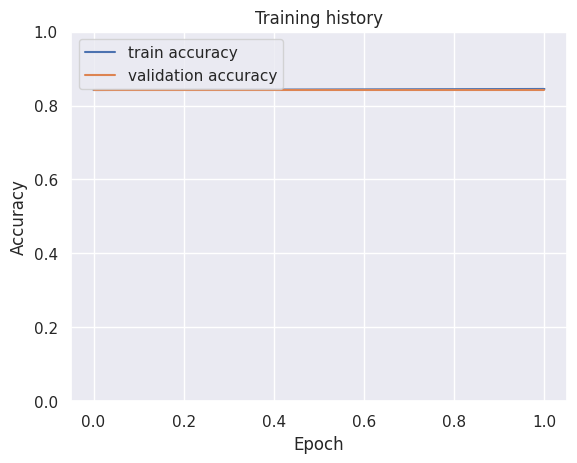

In [50]:

train_acc_cpu = [acc.item() for acc in history['train_acc']]
val_acc_cpu = [acc.item() for acc in history['val_acc']]

plt.plot(train_acc_cpu, label='train accuracy')
plt.plot(val_acc_cpu, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

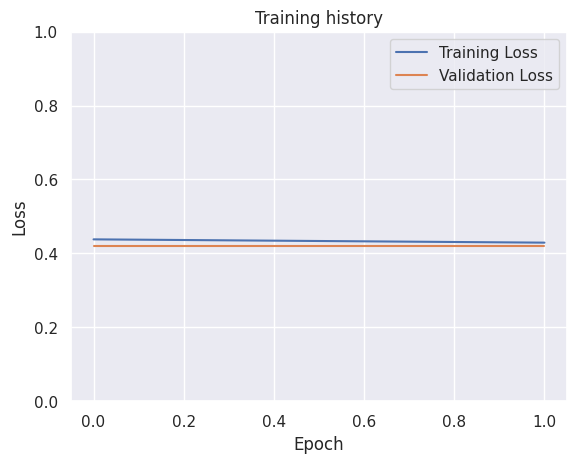

In [51]:
train_acc_cpu = [acc.item() for acc in history['train_loss']]
val_acc_cpu = [acc.item() for acc in history['val_loss']]

plt.plot(train_acc_cpu, label='Training Loss')
plt.plot(val_acc_cpu, label='Validation Loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [52]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_df)
)
test_acc.item()


0.8432045779685265

Evaluating the model based on precision, recall and F-1 scores

In [53]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [54]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [55]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

    negative       0.73      0.89      0.80      3145
    positive       0.89      0.95      0.92      9419
     neutral       0.46      0.06      0.11      1416

    accuracy                           0.84     13980
   macro avg       0.69      0.63      0.61     13980
weighted avg       0.81      0.84      0.81     13980



Show the result on confusion matrix

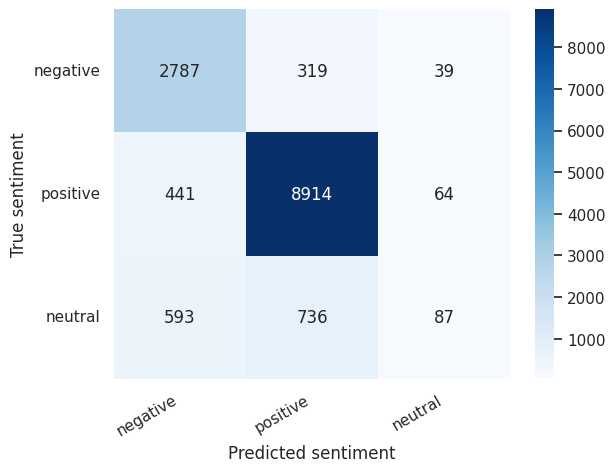

In [56]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

Tested the results by taking an example and looking out for the prection if it gives correct sentiment prediction or not

In [60]:
review_text = "the food was bad and I pucked after eating the food"


In [61]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [62]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_name[prediction]}')

Review text: the food was bad and I pucked after eating the food
Sentiment  : negative


Since the sentiment prediction is true. It can be said that the model is working perfectly fine and can be used for the experiments.

Happy vaccations! Gig'em